In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/myoui/shared/ML/gene_list_para.csv')

In [3]:
label_encoder = LabelEncoder()
df['gene_type_encoded'] = label_encoder.fit_transform(df['gene_type'])

In [4]:
# Vectorize the 'kmers' feature using CountVectorizer
vectorizer = CountVectorizer()
X_kmers = vectorizer.fit_transform(df['kmers'])
X_kmers_df = pd.DataFrame(X_kmers.toarray(), columns=vectorizer.get_feature_names_out())
X_kmers_df.reset_index(drop=True, inplace=True)

In [5]:
# Combine numerical and kmer features
X_numerical = df[['gc_content', 'seq_length', 'mfe', 'dot_count', 'bracket_count']]
X = pd.concat([X_numerical.reset_index(drop=True), X_kmers_df], axis=1)
y = df['gene_type_encoded']

In [6]:
data = df

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Convert y_train and y_test to numpy arrays
y_train = y_train.values
y_test = y_test.values

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Dataset and DataLoader class
class GeneDataset(Dataset):
    def __init__(self, X_feat, y):
        self.X_feat = torch.tensor(X_feat, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_feat[idx], self.y[idx]

train_dataset = GeneDataset(X_train, y_train)
test_dataset = GeneDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
num_classes = len(set(y))
model = SimpleNN(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

train_model(model, train_loader, criterion, optimizer)

Epoch 1/20, Loss: 0.0275
Epoch 2/20, Loss: 0.0038
Epoch 3/20, Loss: 0.0167
Epoch 4/20, Loss: 0.0390
Epoch 5/20, Loss: 0.0007
Epoch 6/20, Loss: 0.0015
Epoch 7/20, Loss: 0.0007
Epoch 8/20, Loss: 0.0002
Epoch 9/20, Loss: 0.0001
Epoch 10/20, Loss: 0.0008
Epoch 11/20, Loss: 0.0001
Epoch 12/20, Loss: 0.0008
Epoch 13/20, Loss: 0.0006
Epoch 14/20, Loss: 0.0016
Epoch 15/20, Loss: 0.0064
Epoch 16/20, Loss: 0.0176
Epoch 17/20, Loss: 0.0001
Epoch 18/20, Loss: 0.0005
Epoch 19/20, Loss: 0.0002
Epoch 20/20, Loss: 0.0000


              precision    recall  f1-score   support

      lncRNA       0.98      0.98      0.98       418
       miRNA       0.82      0.92      0.87       388
    misc_RNA       0.98      0.91      0.94       479
       snRNA       0.98      0.96      0.97       376
      snoRNA       0.80      0.77      0.79       198

    accuracy                           0.92      1859
   macro avg       0.91      0.91      0.91      1859
weighted avg       0.93      0.92      0.92      1859



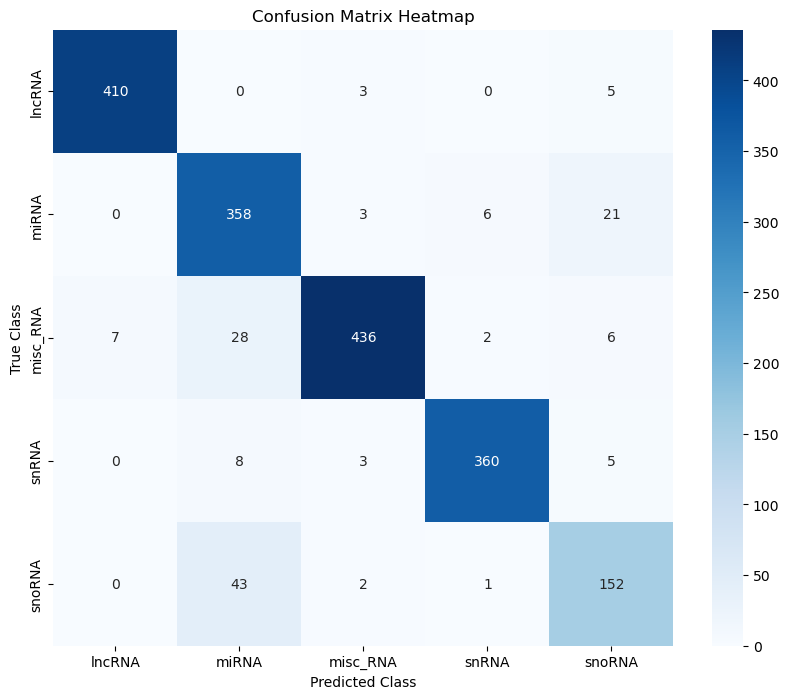

In [14]:
def evaluate_model_with_classification_report(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Generate classification report
    report = classification_report(all_labels, all_predictions, target_names=label_encoder.classes_, output_dict=True)
    
    # Print classification report
    print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

# Call the evaluation function to get the classification report and the heatmap
evaluate_model_with_classification_report(model, test_loader)